# Skapa stdScaler för alla kryptovalutor som vi använder

In [1]:
import pandas as pd
import numpy as np
import time
from pandas.tseries.offsets import DateOffset
from binance.client import Client
from datetime import datetime as dt
import os
from sklearn.preprocessing import StandardScaler
import pickle
import joblib
import matplotlib.pyplot as plt
import yfinance as yf
import preprocess as pp


# GOLD

In [2]:
def get_gold_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    df_dates.set_index('Date', inplace=True)
    # Hämta historiska guldprisdata (GLD är ticker-symbolen för SPDR Gold Shares ETF)
    gld_data = yf.download('GLD', end=dt.today().date(), progress=False)
    # gld_data.set_index('Date', inplace=True)

    # Behåll endast 'Close' priser och döp om kolumnen till 'GLDUSDT'
    gld_data = gld_data[['Close']].rename(columns={'Close': 'GLD-USD'})

    df_dates = pd.DataFrame(pd.date_range(start=gld_data.index[0], end=pd.to_datetime( # type: ignore
        'today').date(), freq='D'), columns=['Date'])  # type: ignore

    df_dates.set_index('Date', inplace=True)
    gld_data = df_dates.merge(gld_data, how='left',
                              left_on='Date', right_index=True)
    # interpolating missing values
    gld_data.interpolate(method='linear', inplace=True)
    return gld_data




In [3]:
df_gold = get_gold_data()

# Inflation

In [4]:
def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(
        id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['Date'] = pd.to_datetime(inflation['Year'].astype(
        str) + '-' + inflation['month'].astype(str))
    inflation.set_index('Date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(
        inflation, how='left', left_on='Date', right_index=True)
    inflation.set_index('Date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(
        chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


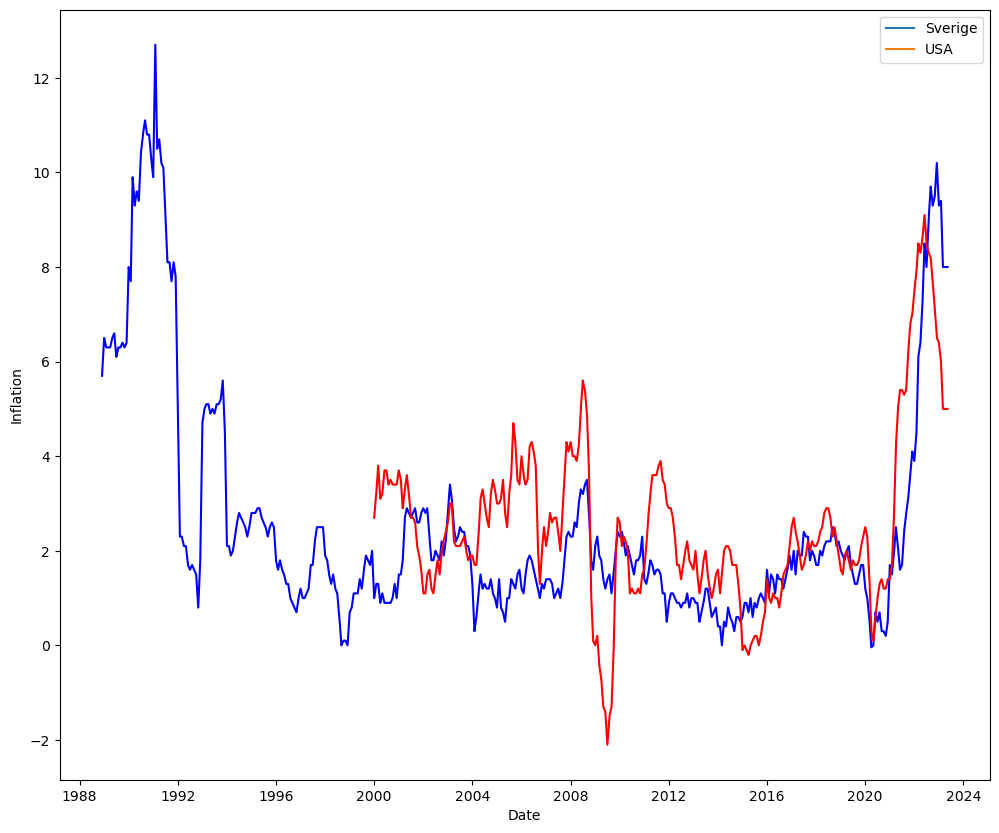

In [5]:

def get_inflation_data(graph=False):
    # Explain this function here
    # Create a dataframe with dates from 1988-12-01 to today
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])

    US_inflation = pd.read_html(
        'https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$',
                         value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    # SE_inflation = pd.DataFrame()
    SE_inflation = pd.read_html(
        'https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')

    SE_inflation = initiate_data(
        SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    # SE_inflation is in percent, divide by 10 to get decimal
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10
    US_inflation = initiate_data(
        US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index,
                SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        # make the lines blue and red
        ax.lines[0].set_color('blue')
        ax.lines[1].set_color('red')
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1).copy()
    inflations = inflations.dropna()
    # inflations = add_horizon_columns(inflations, [75, 90, 250])
   
    return inflations


df_infl = get_inflation_data(graph=True)
# only keep US_inflation
df_infl = df_infl[['US_inflation']]

### all tickers the old way

In [ ]:

df_file = 'all_tickers.csv'

MAX_MONTHS = 24

def set_start_value(df_file):
    # Check if the DataFrame file exists
    if os.path.exists(df_file):
        # Read the existing DataFrame
        df = pd.read_csv(df_file, index_col=0, parse_dates=True)
        
        # Calculate the number of days between today and the last date in the DataFrame
        today = pd.Timestamp(dt.today())
        last_date = df.index[-1]
        antal_dagar = (today - last_date).days # type: ignore
        
        # Set the start date to the number of days ago
        start = f"{antal_dagar} days ago UTC"
    else:
        # If the DataFrame file does not exist, use 24 months as the default
        df = pd.DataFrame()
        start = f"{MAX_MONTHS} month ago UTC"
    return df, start       


In [ ]:
# Get all the tickers from Binance
def get_data():
    # take the time
    start_time = time.time()
    
    api_key = '2jxiCQ8OIWmU4PZH4xfwKEY9KYerDkSWzwNCqoaMzj41eJgWBsSqA3VYqkt2wmdX'
    api_secret = 'YY1Qj1t0JZrE4tQdaBBxT8iwl2tbFalWp1FHjyZ9selBb6OnQ0Oj8aVdiXO7YLMz'

    client = Client(api_key, api_secret)

    # Hämta handelspar
    df, start = set_start_value(df_file)
    print(start)
    if start == '0 days ago UTC':
        return df
    
    symbols = client.get_all_tickers()
    symbols = [
        symbol for symbol in symbols if symbol['symbol'].endswith('USDT')]

    # Sätt upp en tom lista för att lagra close-priser
    close_prices = {}

    # Ange den tidsram du vill ha för historiska data
    interval = Client.KLINE_INTERVAL_1DAY
    
    # Hämta close-priser för alla kryptovalutor
    dates = None

    # progress_bar = st.progress(0)  # Create a progress bar

    for idx, symbol in enumerate(symbols, 1):
        try:
            klines = client.get_historical_klines(
                symbol['symbol'], interval, start)
            if dates is None:
                # Extrahera och konvertera tidsstämplar till datum
                dates = [dt.fromtimestamp(
                    int(kline[0]) / 1000).strftime('%Y-%m-%d') for kline in klines]
            
            close_prices[symbol['symbol']] = [
                float(kline[4]) for kline in klines]
        except Exception as e:
            print(f"Kunde inte hämta data för {symbol['symbol']}: {e}")

        if idx % 10 == 0:
                print(f"This will take several minutes. Symbol number {idx} of {len(symbols)}: . . . . . . . . {symbol['symbol']}")

        # # Update the progress bar
        # if idx+1 == len(symbols):
        #     progress_text = f"Done! last symbol . . . . . . . . {symbol['symbol']} fetched."
        # else:
        #     progress_text = f"This will take several minutes. Symbol number {idx+1} of {len(symbols)}: . . . . . . . . {symbol['symbol']}"
        # progress_bar.progress((idx + 1) / len(symbols), progress_text)
    
    # Konvertera close_prices-dicten till en pandas DataFrame
    # print(close_prices)
    df_new = pd.DataFrame.from_dict(close_prices, orient='index').transpose()
    
    df_new = df_new.dropna(axis=1,how='all')  # remove columns with all nan
    
    # Lägg till datum som index för DataFrame
    
    df_new.index = pd.to_datetime(dates)   # type: ignore
    print(f'Shape of new df {df_new.shape}')
    
    df = pd.concat([df, df_new], axis=0)
    # print the time   
    tot_time = round((time.time() - start_time),1)
    # make it in minutes and seconds
    minutes = tot_time // 60
    seconds = tot_time % 60 
    print(f"Det tog {minutes} minuter och {round(seconds,1)} sekunder att hämta alla kryptovalutor ---")
    return df

df = get_data()
df.to_csv('all_tickers.csv', index=True)


In [ ]:
df.sort_index(inplace=True)
print(df.index)
print(sum(df.index.value_counts()>0) == len(df.index))

print('Nu har vi hämtat alla kryptovalutor med Date som index')

In [ ]:
# Specila preprocessing for crypto data
df = pd.read_csv('all_tickers.csv', index_col=0)

print(df.shape)
# drop the columns where all values are nan
df = df.dropna(axis=1,how='all')
print(df.shape)

s=int(0.9*len(df))

# remove all columns where there are more than s nan values
df = df.dropna(axis=1, thresh=s)

df.shape

In [ ]:
print(f'{df.isna().any().sum()} rader med någon nan \n{len(df)-df.isna().any().sum()} rader utan nan')
# df.isna().any().sum()

### applicera StandardScaler på alla kolumner (tickers) i df
Använd en .py som skapar nya kolumner och preprocessar data - samma .py överallt
StandardScaler får inte ha NaN's
Skapa en folder för alla StandardScalers som sparas

In [ ]:
df.columns

In [ ]:
# Gör en funktion som applicerar StandardScaler() på en ticker och sparar den i en fil uppbyggd av namnet  på ticker.

def fit_and_save_scaler(df, column_name):
    # Kontrollera att kolumnnamnet finns i DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Kolumnen '{column_name}' finns inte i DataFrame")

    # Skapa och träna en StandardScaler med den givna kolumnen
    scaler = StandardScaler()
    scaler.fit(df[[column_name]])

    # Spara StandardScaler i en fil
    file_name = f"scalers/{column_name}_scaler.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump(scaler, f)

    print(f"StandardScaler för kolumn '{column_name}' sparad som '{file_name}'")


# Tester

In [ ]:

# TODO: Se vilka av valutorna från Binance som kan användas i yfinance - Hämta från foldern scalers
# TODO: Om det är tillräckligt många så skit i Binance och använd yfinance
# TODO: preprocess.py skall inte hämta data själv utan få in den som argument och returnera en dataframe

### Testa att skapa en StandardScaler för alla 'godkända' kolumner i df

In [6]:
# läs in ticker-names från filen yf_tickers.txt

def read_ticker_names(filenam):  
    with open(filenam, 'r') as f:
        ticker_names = f.read().splitlines()
    return ticker_names


In [7]:
# hämta yf_tickers från yfinance
def get_yf_data(tickers, time_period='2y'):
    # Hämta historiska data från yfinance
    # yf_data = yf.download(tickers, start='2019-01-01', end=dt.today().date(), progress=False)
    yf_data = yf.download(tickers, interval='1d',
                       period=time_period, group_by='ticker', auto_adjust=True, progress=True)
    # Behåll endast 'Close' priser
    df = pd.DataFrame(yf_data.xs('Close', level=1, axis=1))
    # # Sätt kolumnnamn till tickers
    # yf_data.columns = tickers
    return df



In [ ]:
# Alternativt sätt att få df
if False:
    df = pd.read_csv('all_tickers.csv', index_col=0)
    df.index = pd.to_datetime(df.index)
    print(df.shape)

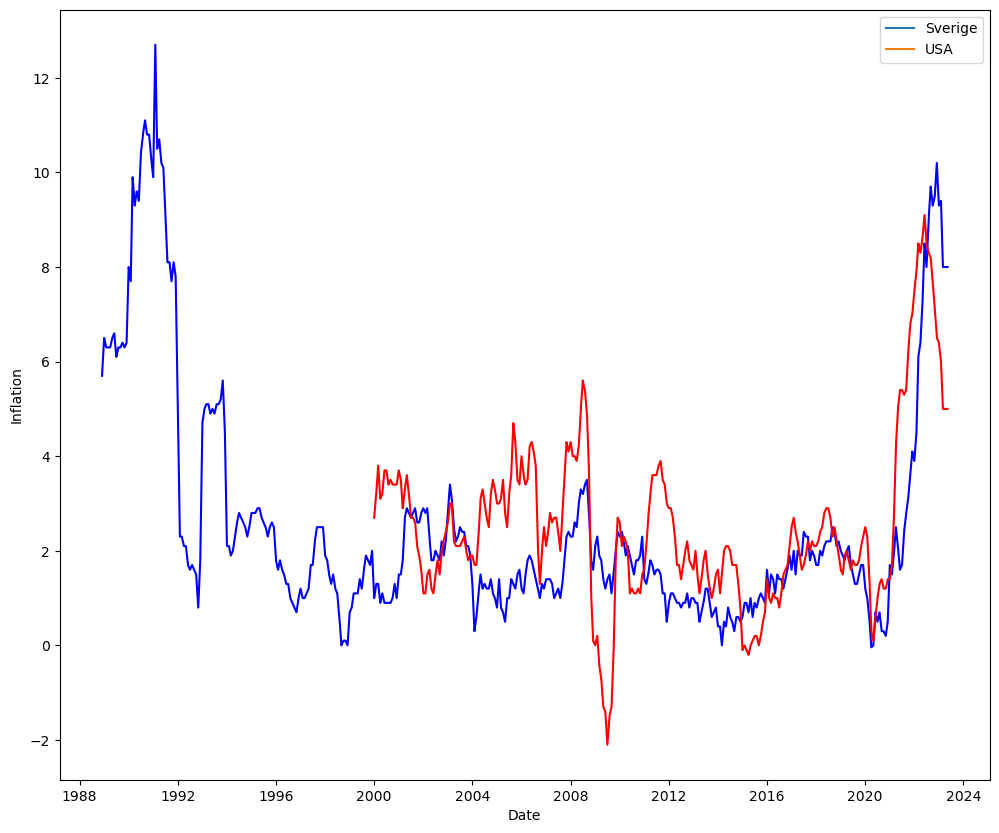

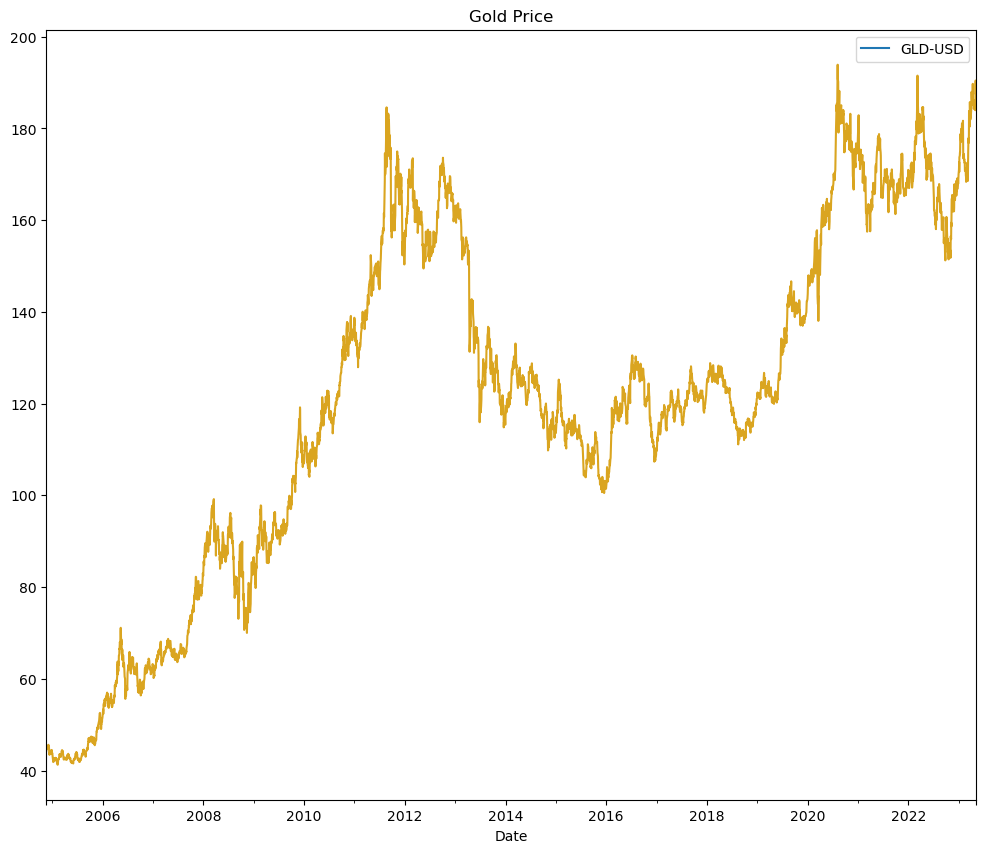

In [8]:
### Hämta US inflation
df_infl = get_inflation_data(graph=True)
# only keep US_inflation
df_infl = df_infl[['US_inflation']]
df_infl.to_csv('inflation.csv')

# Hämta guldpriser
df_gold = get_gold_data()
df_gold.plot(figsize=(12, 10), title='Gold Price')
# make the line golden
plt.gca().lines[0].set_color("goldenrod")
plt.show()
df_gold.to_csv('gold.csv')


In [ ]:
# Hämta och skapa en DataFrame med alla tickers från yfinance
filnamn = 'yf_tickers.txt'
yf_ticker_names = read_ticker_names(filnamn)
print(f'{len(yf_ticker_names)} yFinance ticker_names inlästa')
df = get_yf_data(yf_ticker_names)
display(df.shape)


### Spara undan df som csv

In [ ]:
# spara undan df som csv
if True:
    df.to_csv('df_yf.csv', index=True)

In [9]:
# läs in df från csv
if True:
    df = pd.read_csv('df_yf.csv', index_col=0)
    df.index = pd.to_datetime(df.index)


### Kör preprocessing

In [10]:
display(df.iloc[:,:5].head(3))
df.shape

,GTC-USD,BTT-USD,CAKE-USD,PERL-USD,XLM-USD
Date,,,,,
2021-05-09,0.008833,0.007347,38.301044,0.137236,0.628589
2021-05-10,0.008179,0.006405,36.014393,0.135972,0.659579
2021-05-11,0.010096,0.006851,36.815193,0.143453,0.729996


(731, 321)

In [11]:
# preprocess all of df
df = pp.preprocessing_currency(df)
print('Antal NaN',df.isna().any().sum())

print()
df_dict = {}  # en dictionary med samtlig nya dataframes
for cnt, column_name in enumerate(df.columns):
    df_name = f'df_{column_name}'
    df_dict[df_name]   = pp.preprocess(df[[column_name]], df_gold, df_infl)
    # for each 10th column, print the name
    if (cnt+1) % 10 == 0:
        print(cnt+1,column_name)
    
    
display(df_dict.keys())


321 kolumner totalt
321 kolumner med minst 657 rader utan nan efter dropna
650 rader med någon nan 
508 rader utan nan
Efter interpollate: 0 rader med någon nan 
731 rader utan nan
(731, 321)
Antal NaN 0

10 XEM-USD
20 MINA-USD
30 AUCTION-USD
40 TRIBE-USD
50 PAXG-USD
60 LINK-USD
70 LSK-USD
80 RLC-USD
90 FIL-USD
100 GHST-USD
110 XVS-USD
120 WOO-USD
130 RIF-USD
140 UTK-USD
150 REQ-USD
160 NKN-USD
170 TVK-USD
180 OGN-USD
190 OMG-USD
200 OAX-USD
210 BOND-USD
220 AUTO-USD
230 CHZ-USD
240 BNB-USD
250 ZEN-USD
260 OXT-USD
270 XNO-USD
280 TOMO-USD
290 JASMY-USD
300 NEAR-USD
310 ETH-USD
320 ADA-USD


dict_keys(['df_GTC-USD', 'df_BTT-USD', 'df_CAKE-USD', 'df_PERL-USD', 'df_XLM-USD', 'df_ATA-USD', 'df_ANY-USD', 'df_MDT-USD', 'df_TUSD-USD', 'df_XEM-USD', 'df_YFII-USD', 'df_POLY-USD', 'df_USTC-USD', 'df_ANT-USD', 'df_DUSK-USD', 'df_FIO-USD', 'df_RGT-USD', 'df_ASR-USD', 'df_LINA-USD', 'df_MINA-USD', 'df_DF-USD', 'df_NEBL-USD', 'df_VTHO-USD', 'df_ETHDOWN-USD', 'df_LDO-USD', 'df_MTL-USD', 'df_TLM-USD', 'df_REN-USD', 'df_CVX-USD', 'df_AUCTION-USD', 'df_IOTX-USD', 'df_IRIS-USD', 'df_RAMP-USD', 'df_DATA-USD', 'df_TRB-USD', 'df_ERN-USD', 'df_NEO-USD', 'df_AVA-USD', 'df_SFP-USD', 'df_TRIBE-USD', 'df_KMD-USD', 'df_EOS-USD', 'df_XTZ-USD', 'df_BLZ-USD', 'df_UNI-USD', 'df_RSR-USD', 'df_RNDR-USD', 'df_DCR-USD', 'df_IDEX-USD', 'df_PAXG-USD', 'df_COCOS-USD', 'df_PROM-USD', 'df_SUSD-USD', 'df_DNT-USD', 'df_BNT-USD', 'df_AVAX-USD', 'df_SLP-USD', 'df_LUNC-USD', 'df_DOCK-USD', 'df_LINK-USD', 'df_USDP-USD', 'df_TCT-USD', 'df_FIRO-USD', 'df_WBTC-USD', 'df_HIVE-USD', 'df_CTSI-USD', 'df_FET-USD', 'df_BUSD-US

In [12]:
# print första elementet i df_dict
first_key = list(df_dict.keys())[0]
display(df_dict[first_key])

,GTC-USD,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,...,infl_Ratio_90,infl_Ratio_250,GLD-USD,GLD_Ratio_2,GLD_Ratio_5,GLD_Ratio_30,GLD_Ratio_60,GLD_Ratio_90,GLD_Ratio_250,diff
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-10,0.008179,0.961557,0.008179,0.961557,0.008179,0.961557,0.008179,0.961557,0.008179,0.961557,...,1.370092,2.299436,172.110001,1.000504,1.003604,1.031257,1.046249,1.045412,1.000090,0.000000
2021-05-11,0.010096,1.104897,0.009137,1.117309,0.009137,1.117309,0.009137,1.117309,0.009137,1.117309,...,1.360834,2.289830,172.139999,1.000087,1.001350,1.029478,1.045303,1.045635,1.000474,0.000000
2021-05-12,0.008954,0.940052,0.009525,0.993178,0.009076,0.993178,0.009076,0.993178,0.009076,0.993178,...,1.351822,2.280271,170.429993,0.995008,0.992742,1.017598,1.034009,1.035302,0.990793,0.000449
2021-05-13,0.008519,0.975104,0.008737,0.955452,0.008937,0.955452,0.008937,0.955452,0.008937,0.955452,...,1.343047,2.270762,171.130005,1.002049,0.997556,1.020214,1.037294,1.039524,0.995104,0.000200
2021-05-14,0.009074,1.031547,0.008797,1.012226,0.008964,1.014705,0.008964,1.014705,0.008964,1.014705,...,1.334502,2.261300,172.690002,1.004537,1.005766,1.027478,1.045642,1.048815,1.004380,0.000168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-20,0.000559,0.962963,0.000580,0.960151,0.000582,0.862921,0.000648,0.810556,0.000690,0.909354,...,0.944680,0.770273,186.089996,1.001965,1.001521,1.004891,1.036682,1.044154,1.107880,0.000132
2023-04-27,0.000547,0.989150,0.000553,0.939863,0.000582,0.853620,0.000641,0.793789,0.000689,0.889318,...,0.960248,0.781219,184.750000,1.000027,0.999001,0.995944,1.019091,1.034395,1.096184,0.000158
2023-04-29,0.000552,1.004550,0.000549,0.962008,0.000574,0.870479,0.000634,0.800658,0.000689,0.896961,...,0.964550,0.784390,184.523336,0.999251,0.997895,0.994256,1.014992,1.032398,1.093653,0.000159


#### Rensa i df med krypto 

### Hämta valutor från Binance med asyncio för ipynb

In [ ]:
# Hämta kryptovalutor asynkront för en ipynb-fil
import pandas as pd
from datetime import datetime
from binance.client import Client
import httpx
import asyncio
# set timer
start_time = datetime.now()

# Ange din API-nyckel och hemliga nyckel från Binance här
api_key = '2jxiCQ8OIWmU4PZH4xfwKEY9KYerDkSWzwNCqoaMzj41eJgWBsSqA3VYqkt2wmdX'
api_secret = 'YY1Qj1t0JZrE4tQdaBBxT8iwl2tbFalWp1FHjyZ9selBb6OnQ0Oj8aVdiXO7YLMz'

# Ange valutorna du vill ladda ner
cryptos = ['BTCUSDT', 'ETHUSDT', 'BCHUSDT', 'XRPUSDT', 'ZRXUSDT',
           'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'DOTUSDT', 'AVAXUSDT']


async def get_historical_klines_async(symbol):
    base_url = "https://api.binance.com"
    interval = "1d"
    _24_months_in_seconds = int(24 * 30.44 * 24 * 60 * 60)
    
    # Current timestamp in milliseconds
    end_time = int(datetime.now().timestamp() * 1000)
    # 24 months ago timestamp in milliseconds
    start_time = end_time - (_24_months_in_seconds * 1000)
    url = f"{base_url}/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}"
    async with httpx.AsyncClient() as client:
        response = await client.get(url)
    return response.json()


async def main():
    tasks = [get_historical_klines_async(symbol) for symbol in cryptos]
    klines = await asyncio.gather(*tasks)

    close_prices_list = []
    timestamps_list = []
    for crypto_data in klines:
        close_prices = [float(kline[4]) for kline in crypto_data]
        timestamps = [int(kline[0]) for kline in crypto_data]
        close_prices_list.append(close_prices)
        timestamps_list.append(timestamps)

    # Konvertera close_prices_list till en pandas DataFrame
    data = {symbol: prices for symbol,
            prices in zip(cryptos, close_prices_list)}
    df = pd.DataFrame(data)

    # Hämta tidpunkterna för varje datapunkt och konvertera dem till datetime-objekt
    dates = pd.to_datetime(timestamps_list[0], unit='ms')

    # Sätt Date som index för DataFrame
    df.index = dates

    # Visa DataFrame
    display(df)

# Kör asynkron kod i Jupyter Notebook
await main()

# print the elapsed time  
elapsed_time = datetime.now() - start_time 
# round to seconds
elapsed_seconds = round(elapsed_time.total_seconds(),1)

print('elapsed time',elapsed_seconds,)
#%%


### En lista över alla tillgängliga kryptovalutor i Binance

In [ ]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
unique_cryptos = {}
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    symbols_data = data["symbols"]

    # Extrahera unika kryptovalutor från handelsparen
    unique_cryptos = set()
    for symbol_info in symbols_data:
        base_asset = symbol_info["baseAsset"]
        quote_asset = symbol_info["quoteAsset"]
        unique_cryptos.add(base_asset)
        unique_cryptos.add(quote_asset)

    print("Unique cryptocurrencies on Binance:", unique_cryptos)
else:
    print("Failed to fetch exchange info")

print(len(unique_cryptos))
# selektera alla som slutar på USDT
